In [1]:
import yfinance as yf

In [2]:
df = yf.download('AAPL', start="2010-01-01")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470742,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481931,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367032,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409364,447610800
...,...,...,...,...,...,...
2024-04-01,171.190002,171.250000,169.479996,170.029999,170.029999,46240500
2024-04-02,169.080002,169.339996,168.229996,168.839996,168.839996,49329500
2024-04-03,168.789993,170.679993,168.580002,169.649994,169.649994,47691700


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df[['Close']])

In [4]:
df_scaled

array([[0.00410081],
       [0.00416991],
       [0.00353313],
       ...,
       [0.85119034],
       [0.84685057],
       [0.85082437]])

In [5]:
import numpy as np

def train_test_split(data, train_ratio, seq_len):
    X = []
    y = []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    split = int(len(data) * train_ratio)
    X_train = np.array(X[:split])
    X_test = np.array(X[split:])
    y_train = np.array(y[:split])
    y_test = np.array(y[split:])

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, 0.9, 20)

In [7]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3229, 20, 1)
X_test shape: (339, 20, 1)
y_train shape: (3229, 1)
y_test shape: (339, 1)


In [8]:
import torch

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: torch.Size([3229, 20, 1])
X_test shape: torch.Size([339, 20, 1])
y_train shape: torch.Size([3229, 1])
y_test shape: torch.Size([339, 1])


In [10]:
class GRU(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
learning_rate = 0.01
num_epochs = 200

In [12]:
model = GRU(input_dim, hidden_dim, num_layers, output_dim)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred = model(X_train)

    mse = loss(y_train_pred, y_train)
    print("Epoch", t+1, "- MSE:", mse.item())
    hist[t] = mse.item()

    optimizer.zero_grad()
    mse.backward()
    optimizer.step()

Epoch 1 - MSE: 0.13680969178676605
Epoch 2 - MSE: 0.05497302860021591
Epoch 3 - MSE: 0.08152727037668228
Epoch 4 - MSE: 0.05130142718553543
Epoch 5 - MSE: 0.03743825852870941
Epoch 6 - MSE: 0.0410209596157074
Epoch 7 - MSE: 0.04050804302096367
Epoch 8 - MSE: 0.029402390122413635
Epoch 9 - MSE: 0.014852847903966904
Epoch 10 - MSE: 0.008942515589296818
Epoch 11 - MSE: 0.013417800888419151
Epoch 12 - MSE: 0.007972829975187778
Epoch 13 - MSE: 0.0013433739077299833
Epoch 14 - MSE: 0.009668324142694473
Epoch 15 - MSE: 0.011196797713637352
Epoch 16 - MSE: 0.003886692225933075
Epoch 17 - MSE: 0.0002698100870475173
Epoch 18 - MSE: 0.0019244024297222495
Epoch 19 - MSE: 0.003951437771320343
Epoch 20 - MSE: 0.003885508980602026
Epoch 21 - MSE: 0.0029134394135326147
Epoch 22 - MSE: 0.002516099950298667
Epoch 23 - MSE: 0.0028092002030462027
Epoch 24 - MSE: 0.003054247237741947
Epoch 25 - MSE: 0.0026106960140168667
Epoch 26 - MSE: 0.0014882722171023488
Epoch 27 - MSE: 0.0003749692114070058
Epoch 28 -

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

actual = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))

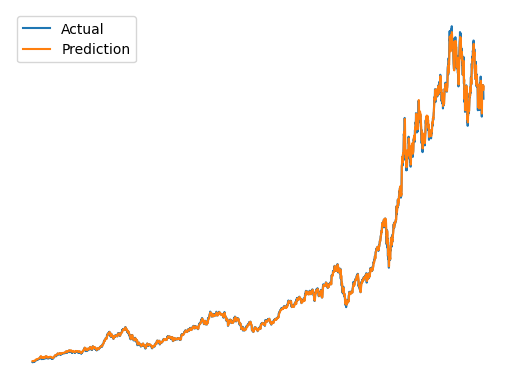

In [15]:
plt.plot(actual.index, actual[0], label='Actual')
plt.plot(predict.index, predict[0], label='Prediction')
plt.axis('off')
plt.legend()

Text(0, 0.5, 'Error')

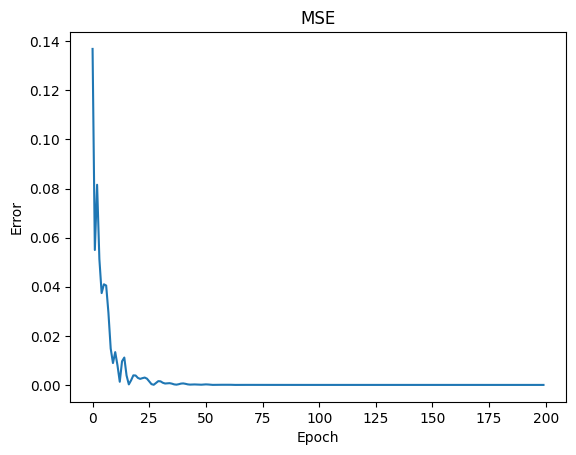

In [16]:
plt.plot(hist)
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('Error')

In [17]:
y_test_pred = model(X_test)

train_actual = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))
train_predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
test_actual = pd.DataFrame(scaler.inverse_transform(y_test.detach().numpy()))
test_predict = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))

In [18]:
from sklearn.metrics import mean_squared_error
import math

In [19]:
print('Train MSE:', math.sqrt(mean_squared_error(train_actual.loc[:,0], train_predict.loc[:,0])))
print('Test MSE:', math.sqrt(mean_squared_error(test_actual.loc[:,0], test_predict.loc[:,0])))

Train MSE: 1.4318294634794302
Test MSE: 3.097833577837351
